Importação de dependências

In [465]:
import re
import numpy as np
import pandas as pd

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

Carregando o dataset

In [466]:
df = pd.read_csv("Tweets.csv")
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


Limpando e reduzindo o dataset

In [468]:
tweets = df[['textID', 'text', 'sentiment']]
tweets = tweets.dropna()
tweets.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

Atribuindo uma target com valor numérico.

Como queremos uma classificação binária, iremos substituir os dados neutros pelos valores 0 ou 1 gerados randomicamente com a biblioteca numpy. 

In [469]:
tweets['target'] = 0

len_neutral = len(tweets.loc[tweets['sentiment'] == 'neutral'])
tweets['target'].loc[tweets['sentiment'] == 'neutral'] = np.random.choice([0,1], size=len_neutral)

tweets['target'].loc[tweets['sentiment'] == 'negative'] = 0
tweets['target'].loc[tweets['sentiment'] == 'positive'] = 1

tweets.head()

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/1406044914.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  tweets['target'].loc[tweets['sentiment'] == 'neutral'] = np.random.choice([0,1], size=len_neutral)
/var/folders/q

,textID,text,sentiment,target
0,cb774db0d1,"I`d have responded, if I were going",neutral,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,0
2,088c60f138,my boss is bullying me...,negative,0
3,9642c003ef,what interview! leave me alone,negative,0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,0


In [470]:
tweets['target'].value_counts()

target
1    14080
0    13400
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

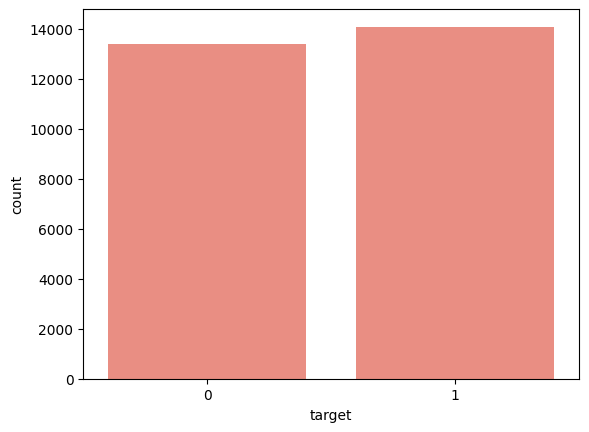

In [471]:
sns.countplot(x='target', data=tweets, color='salmon')


In [472]:
dataset = tweets[['text', 'target']]
dataset['text']=dataset['text'].str.lower()

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/3541435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']=dataset['text'].str.lower()


Definindo as preposições inglesas.

In [473]:
preposicoes_ingles = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

STOPWORDS = set(preposicoes_ingles)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/2722975467.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))


Limpando e removendo pontuações.

In [474]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/1585830442.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))


Limpando e removendo caracteres repetidos.

In [475]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/121656899.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))


Limpando e removendo URLs.

In [476]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/376641464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))


Limpando e removendo dados numéricos.

In [477]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/1738123132.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))


In [478]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/1592489713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(tokenizer.tokenize)


Aplicando stemming

In [479]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/3677059698.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))


Applying lemmatizer

In [480]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return text
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/3580761906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))


In [481]:
def concatenar_lista(lista):
    return ' '.join(lista)

dataset['text'] = dataset['text'].apply(concatenar_lista)

/var/folders/qs/9xylwfbj4dd_v348mgh78zv40000gn/T/ipykernel_70953/3447728039.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['text'] = dataset['text'].apply(concatenar_lista)


Dividindo o dataset em treino e teste

In [482]:
from sklearn.model_selection import train_test_split

X = dataset.text
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamanho do conjunto de treinamento (X_train):", X_train.shape)
print("Tamanho do conjunto de teste (X_test):", X_test.shape)
print("Tamanho do conjunto de treinamento do target (y_train):", y_train.shape)
print("Tamanho do conjunto de teste do target (y_test):", y_test.shape)

Tamanho do conjunto de treinamento (X_train): (21984,)
Tamanho do conjunto de teste (X_test): (5496,)
Tamanho do conjunto de treinamento do target (y_train): (21984,)
Tamanho do conjunto de teste do target (y_test): (5496,)


Transformando o dataset usando TF-DI Vectorizer

In [483]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

No. of feature_words:  127384


## Função para avaliar o modelo
Após treinar o modelo, aplicamos então as medidas de avaliação para verificar o desempenho do modelo. Assim, usamos os seguintes parâmetros de avaliação para verificar o desempenho dos modelos, respectivamente:

Pontuação de Acurácia
Matriz de Confusão com Gráfico
Curva ROC-AUC

In [485]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Oranges' ,fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

## Regressão Logística

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      2694
           1       0.73      0.71      0.72      2802

    accuracy                           0.72      5496
   macro avg       0.72      0.72      0.72      5496
weighted avg       0.72      0.72      0.72      5496



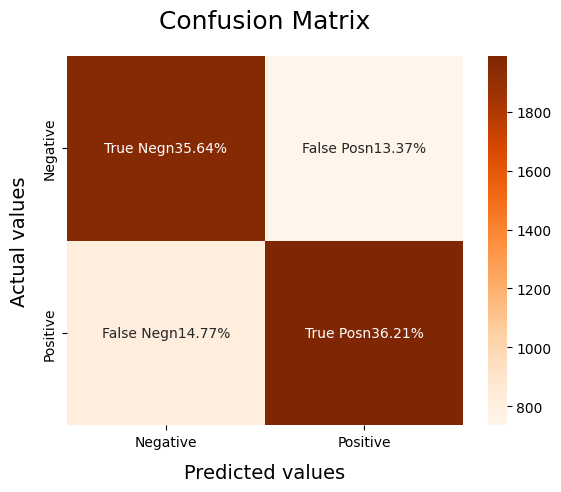

In [486]:
log_reg = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
log_reg.fit(X_train, y_train)
model_Evaluate(log_reg)
y_pred = log_reg.predict(X_test)

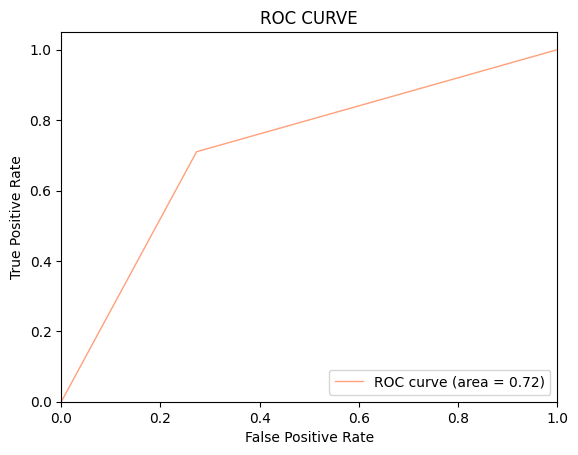

In [487]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='lightsalmon', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()